## Migraine Prediction Using Deep Neural Networks (DNNs)
In this notebook, the target is to classify the type of migraine (a type of headache), given a set of features that are extracted from patient's medical records.In our approach, we'll make use of deep neural networks (DNNs) for classification of migraine headache into **7** possible classes.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/migraine-classification/data.csv


In [58]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score

## Data Loading
The first step is to load dataset into memory. The dataset is already been provided to us in the form of a table.

In [4]:
# loading dataset
data = pd.read_csv('../input/migraine-classification/data.csv')

In [5]:
data.shape

(400, 24)

The dataset has **400** training examples & **24** set of features.

In [6]:
print('Number of training examples: %s' % str(data.shape[0]))
print('Number of features: %s' % str(data.shape[1]))

Number of training examples: 400
Number of features: 24


## EDA (Explorarory Data Analysis)
First, we'll make a bried go-through of data using data analysis techniques. The purpose of this step is to make a deeper understanding of how does the data look like, and what useful insights can be drawn from data after EDA process.

In [7]:
data.columns

Index(['Age', 'Duration', 'Frequency', 'Location', 'Character', 'Intensity',
       'Nausea', 'Vomit', 'Phonophobia', 'Photophobia', 'Visual', 'Sensory',
       'Dysphasia', 'Dysarthria', 'Vertigo', 'Tinnitus', 'Hypoacusis',
       'Diplopia', 'Defect', 'Ataxia', 'Conscience', 'Paresthesia', 'DPF',
       'Type'],
      dtype='object')

In [8]:
data['Type'].value_counts()

Typical aura with migraine       247
Migraine without aura             60
Familial hemiplegic migraine      24
Typical aura without migraine     20
Basilar-type aura                 18
Other                             17
Sporadic hemiplegic migraine      14
Name: Type, dtype: int64

In [9]:
data.Age.min(), data.Age.max()

(15, 77)

In [17]:
# data['Age'].value_counts()

<AxesSubplot:title={'center':'Range of Patient Age in Dataset '}>

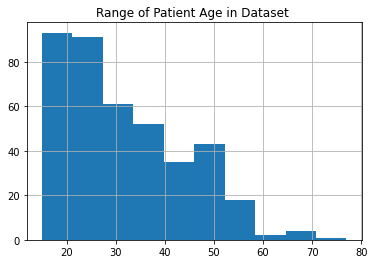

In [10]:
plt.title('Range of Patient Age in Dataset ')
data['Age'].hist()

In [11]:
data.Character.value_counts()

1    369
0     20
2     11
Name: Character, dtype: int64

<AxesSubplot:xlabel='Character', ylabel='count'>

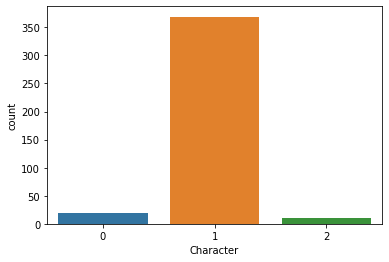

In [12]:
sns.countplot(x=data['Character'])

<AxesSubplot:xlabel='Defect', ylabel='count'>

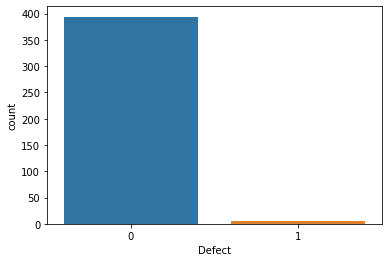

In [13]:
sns.countplot(x=data.Defect)

In [14]:
data.Type.value_counts()

Typical aura with migraine       247
Migraine without aura             60
Familial hemiplegic migraine      24
Typical aura without migraine     20
Basilar-type aura                 18
Other                             17
Sporadic hemiplegic migraine      14
Name: Type, dtype: int64

<AxesSubplot:xlabel='Type', ylabel='count'>

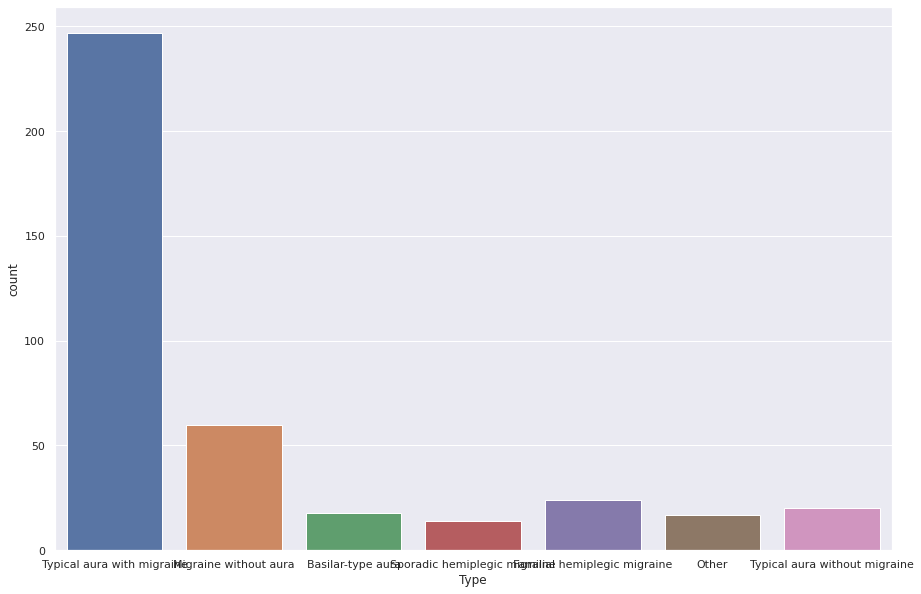

In [15]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.countplot(x=data.Type)

For making a more clear picture of our target distribution, we draw a circled plot to draw more useful insights.

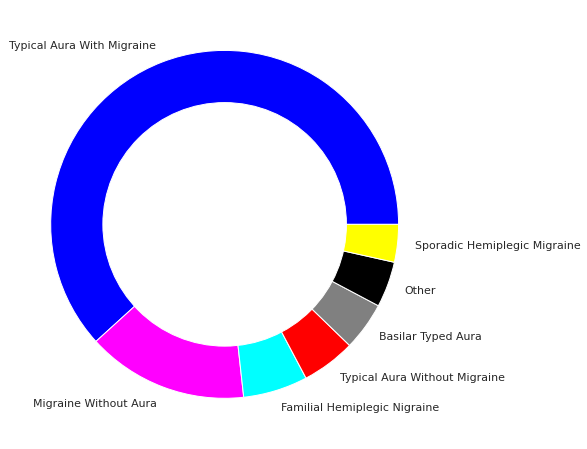

In [18]:
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(data.Type.value_counts(), labels=['Typical Aura With Migraine', 'Migraine Without Aura', 'Familial Hemiplegic Nigraine',
                                                'Typical Aura Without Migraine', 'Basilar Typed Aura', 
                                         'Other', 'Sporadic Hemiplegic Migraine'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey', 'black', 'yellow'])
p = plt.gcf()
p.gca().add_artist(circle)

From the figure, it can be seen that:
- The most common type of migraine in the dataset is **Typical Aura With Migraine**
- **Migraine Wtihout Aura** holds the second position with second most common place
- Other 5 types of heartbeats in the dataset are less frequent as compared to the first two

It can be given from dataset that the data is imbalanced, i.e., most of the training examples belong to Typical Aura With Migraine, while the percentage of other features are less. Therefore, this class imbalance needs to be reduced in order to make a successful model.

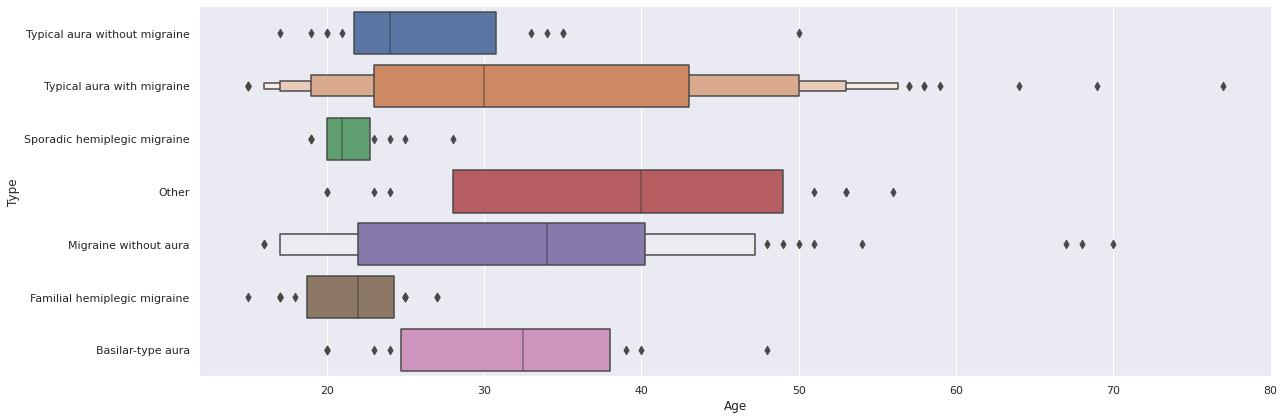

In [19]:
# cgecking for some outliers in dataset
sns.catplot(y='Type', x='Age', data=data.sort_values("Type", ascending=False),
           kind='boxen', height=6, aspect=3)

In [20]:
# checking for some null, missing or NaN values
data.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

## Sampling Dataset
We have unequal number of samples in each class of dataset, which means that we are dealing with imbalanced classification. We need to resample the dataset in order to make a machine learning model that learns all instances well. For this, we'll apply random oversampling & undersampling techniques.

For undergoing this procedure, we'll follow following steps:
- First, we extract the features of each class from dataset
- Then, we apply sampling to each of the classes by assigning equal number of instances to each class
- Then we concatenate each of the dataframes in a single dataframe that contains equal samples of each class

In [21]:
# as there are 7 classes, so there will be 7 different dataframes
data_1 = data[data['Type'] == 'Typical aura with migraine']
data_2 = data[data['Type'] == 'Migraine without aura']
data_3 = data[data['Type'] == 'Familial hemiplegic migraine']
data_4 = data[data['Type'] == 'Typical aura without migraine']
data_5 = data[data['Type'] == 'Basilar-type aura']
data_6 = data[data['Type'] == 'Other']
data_7 = data[data['Type'] == 'Sporadic hemiplegic migraine']

In [22]:
data.shape

(400, 24)

In [23]:
400/7

57.142857142857146

In [24]:
# applying resampling through sampling function in sklearn
from sklearn.utils import resample

# we will put 200 samples in each class
data_1_resample = resample(data_1, n_samples=200, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=200, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=200, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=200, 
                           random_state=123, replace=True)
data_5_resample = resample(data_5, n_samples=200, 
                           random_state=123, replace=True)
data_6_resample = resample(data_6, n_samples=200, 
                           random_state=123, replace=True)
data_7_resample = resample(data_7, n_samples=200, 
                           random_state=123, replace=True)

In [25]:
train_dataset = pd.concat([data_1, data_2_resample, data_3_resample, data_4_resample, 
                          data_5_resample, data_6_resample, data_7_resample])

In [26]:
train_dataset.head(3)

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine
1,50,3,5,1,1,3,1,1,1,1,...,1,0,0,0,0,0,0,0,0,Typical aura with migraine
2,53,2,1,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine


In [27]:
train_dataset.shape

(1447, 24)

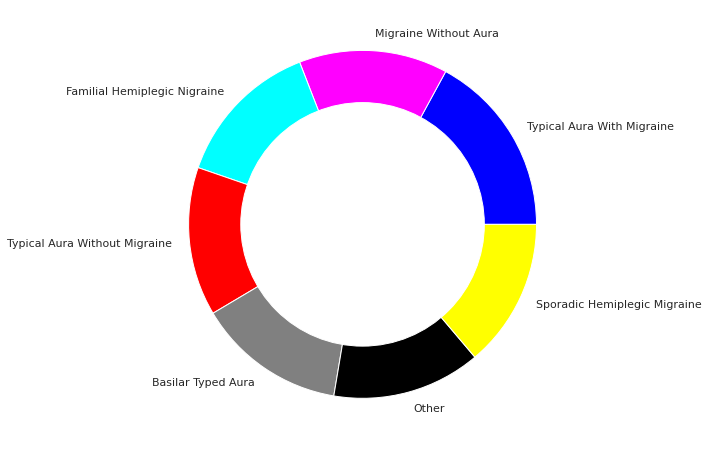

In [28]:
# viewing the sample distribution of classes again

plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_dataset.Type.value_counts(), labels=['Typical Aura With Migraine', 'Migraine Without Aura', 'Familial Hemiplegic Nigraine',
                                                'Typical Aura Without Migraine', 'Basilar Typed Aura', 
                                         'Other', 'Sporadic Hemiplegic Migraine'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey', 'black', 'yellow'])
p = plt.gcf()
p.gca().add_artist(circle)

After undergoing the re-sampling step, we have now arrived at a point where we have equal number of samples of each class. 

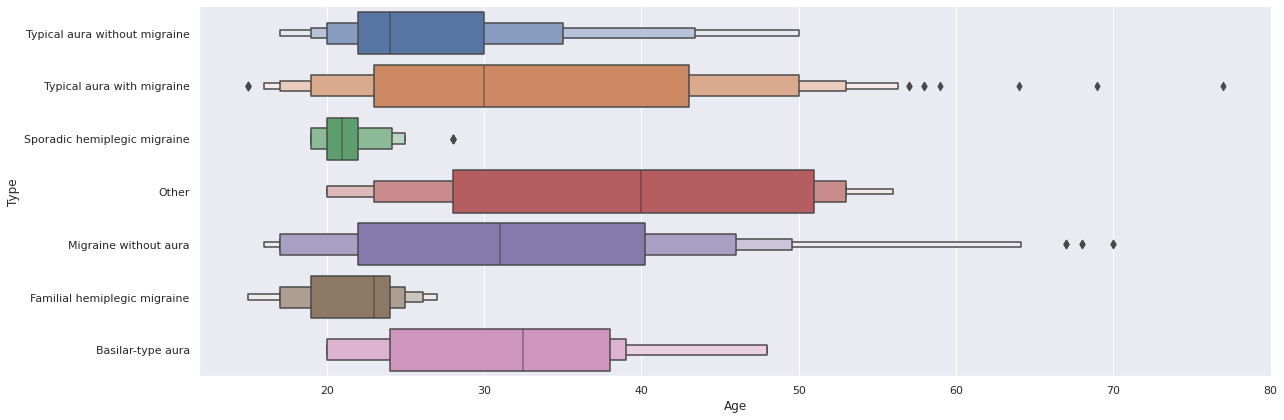

In [29]:
sns.catplot(y='Type', x='Age', data=train_dataset.sort_values("Type", ascending=False),
           kind='boxen', height=6, aspect=3)

## Selecting X & Y Variables
Selecting predictor (X) variables & Y (target) variables for our modl. The target column will be the type of migraine, and all other features will be features.

In [30]:
X = train_dataset.drop('Type', axis=1)
Y = train_dataset['Type']

In [31]:
X.shape, Y.shape

((1447, 23), (1447,))

In [32]:
X.head(5)

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Dysarthria,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,50,3,5,1,1,3,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2,53,2,1,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,45,3,5,1,1,3,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
4,53,1,1,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [33]:
Y.head(5)

0    Typical aura with migraine
1    Typical aura with migraine
2    Typical aura with migraine
3    Typical aura with migraine
4    Typical aura with migraine
Name: Type, dtype: object

## Data Splicing (Split into Train & Test Sets)

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                  Y, 
                                                  test_size=0.2, 
                                                  random_state=123)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1157, 23)
(290, 23)
(1157,)
(290,)


In [53]:
X_arr = np.array(X)
X_arr.shape, X.shape

((1447, 23), (1447, 23))

In [54]:
X_arr

array([[30,  1,  5, ...,  0,  0,  0],
       [50,  3,  5, ...,  0,  0,  0],
       [53,  2,  1, ...,  0,  0,  0],
       ...,
       [21,  1,  1, ...,  0,  0,  0],
       [19,  1,  2, ...,  0,  0,  0],
       [24,  1,  1, ...,  0,  0,  0]])

In [57]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [59]:
labelled_Y = to_categorical(encoded_Y)

In [61]:
labelled_Y.shape

(1447, 7)

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                  labelled_Y, 
                                                  test_size=0.2, 
                                                  random_state=123)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1157, 23)
(290, 23)
(1157, 7)
(290, 7)


## Applying Deep Neural Networks (DNNs)
In below step, now we apply deep neural networks (DNNs) to our dataset for migraine classification into 7 possible classes. This process can be broken down as:
* First, we'll make a deep neural network with one architecture
* Second, we'll make a deep neural network with different architcure

### DNN With One Architecture

In [65]:
def naural_natwork():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_arr.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [66]:
model = naural_natwork()

# compiling the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# setting a callback for controlling model's performance
callback = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)


# fitting the model to training data
model.fit(X_train, Y_train, 
          epochs=100, 
          validation_data=(X_test, Y_test), verbose=1)

Epoch 1/100
37/37 [==============================] - 1s 11ms/step - loss: 1.7771 - accuracy: 0.3276 - val_loss: 1.3565 - val_accuracy: 0.5345
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 1.0489 - accuracy: 0.6508 - val_loss: 0.7850 - val_accuracy: 0.6966
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 0.7338 - accuracy: 0.7476 - val_loss: 0.6300 - val_accuracy: 0.7586
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 0.6142 - accuracy: 0.7770 - val_loss: 0.4215 - val_accuracy: 0.8793
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 0.3827 - accuracy: 0.8799 - val_loss: 0.5320 - val_accuracy: 0.7931
Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 0.3212 - accuracy: 0.8954 - val_loss: 0.3335 - val_accuracy: 0.8724
Epoch 7/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2820 - accuracy: 0.9041 - val_loss: 0.3433 - val_accuracy: 0.8828
Epoch 8/100


In [79]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               12288     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 903       
Total params: 177,415
Trainable params: 177,415
Non-trainable params: 0
_________________________________________________________________


### Visualizing Model's Performance of First DNN

In [72]:
hist = model.history.history

dict

In [73]:
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [75]:
acc, val_acc = hist['accuracy'], hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

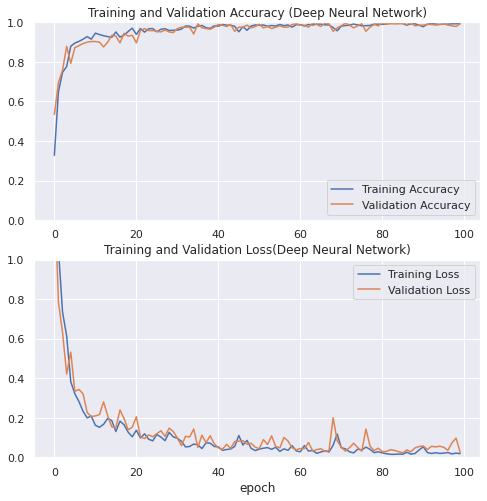

In [82]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Deep Neural Network V1)')

print('')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss(Deep Neural Network V2)')
plt.xlabel('epoch')
plt.show()

### DNN with Second Architecture
Now, we'll implement another deep neural network containing a different architcure. 

In [87]:
def neural_network_2():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_arr.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [88]:
model_2 = neural_network_2()
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               6144      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 455       
Total params: 47,751
Trainable params: 47,751
Non-trainable params: 0
_________________________________________________________________


In [91]:
# compiling the model
model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# setting a callback for controlling model's performance
callback = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)


# fitting the model to training data
model_2.fit(X_train, Y_train, 
          epochs=100, 
          validation_data=(X_test, Y_test), 
          verbose=1)

Epoch 1/100
37/37 [==============================] - 1s 10ms/step - loss: 1.8110 - accuracy: 0.2550 - val_loss: 1.5752 - val_accuracy: 0.5207
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 1.3869 - accuracy: 0.4797 - val_loss: 1.1987 - val_accuracy: 0.5586
Epoch 3/100
37/37 [==============================] - 0s 5ms/step - loss: 1.0503 - accuracy: 0.6534 - val_loss: 1.0224 - val_accuracy: 0.6241
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 0.8594 - accuracy: 0.7329 - val_loss: 0.6899 - val_accuracy: 0.7793
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 0.6354 - accuracy: 0.7822 - val_loss: 0.6840 - val_accuracy: 0.7448
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 0.5459 - accuracy: 0.8254 - val_loss: 0.4361 - val_accuracy: 0.8586
Epoch 7/100
37/37 [==============================] - 0s 7ms/step - loss: 0.4020 - accuracy: 0.8816 - val_loss: 0.4172 - val_accuracy: 0.8517
Epoch 8/100


In [92]:
hist_2 = model_2.history.history

In [93]:
acc_2, val_acc_2 = hist_2['accuracy'], hist_2['val_accuracy']
loss_2 = hist_2['loss']
val_loss_2 = hist_2['val_loss']

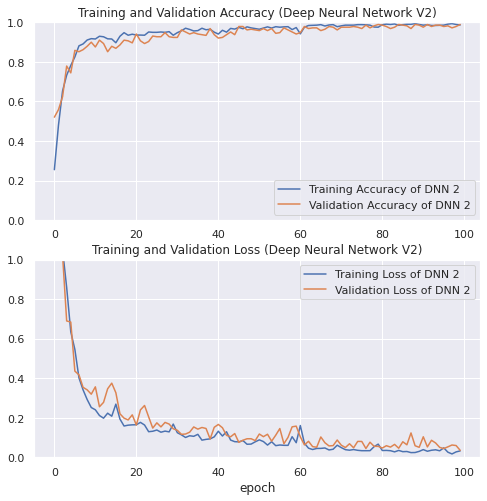

In [95]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_2, label='Training Accuracy of DNN 2')
plt.plot(val_acc_2, label='Validation Accuracy of DNN 2')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Deep Neural Network V2)')

print('')

plt.subplot(2, 1, 2)
plt.plot(loss_2, label='Training Loss of DNN 2')
plt.plot(val_loss_2, label='Validation Loss of DNN 2')
plt.ylim([0, 1.0])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Deep Neural Network V2)')
plt.xlabel('epoch')
plt.show()

## Comparing Performances of Deep Neural Networks (DNNs)
Now, we compare the performances (Loss & Accuracy) of both neural networks on testing dataset.

In [104]:
# evaluate the model
score = model.evaluate(X_test, Y_test)
score_2 = model_2.evaluate(X_test, Y_test)

# print accuracies of models 
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))
print('Accuracy of First Deep Neural Network: %.2f' % (score[1]*100))
print('Loss of First Deep Neural Network: %.4f' % (score[0]))

print('')

print("%s: %.2f%%" % (model_2.metrics_names[1], score_2[1] * 100))
print('Accuracy of Second Deep Neural Network: %.2f' % (score_2[1]*100))
print('Loss of Second Deep Neural Network: %.4f' % (score_2[0]))

10/10 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9897
accuracy: 98.97%
Accuracy of First Deep Neural Network: 98.97
Loss of First Deep Neural Network: 0.0438

accuracy: 98.97%
Accuracy of Second Deep Neural Network: 98.97
Loss of Second Deep Neural Network: 0.0352


Both the neural networks performed exceptionally well on testing dataset, attaining an accuracy of 98.9%. The loss of both neural networks were extremely low on testing data, with first neural network attaining a loss of 0.0438 & second neural network attaining a loss of 0.0352.

In [129]:
y_hat_nn1 = model.predict(X_test)
pred_nn1 = np.argmax(model.predict(X_test), axis=1)
Y_test_class_1 = np.argmax(Y_test, axis=1)

In [139]:
print('Classification Report of Deep Neural Network 1')
print(classification_report(Y_test_class_1, pred_nn1))

Classification Report of Deep Neural Network 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.91      1.00      0.95        31
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00        36
           5       1.00      0.94      0.97        52
           6       1.00      1.00      1.00        43

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290



In [135]:
# classification report of second neural network
y_hat_nn2 = model_2.predict(X_test)
pred_nn2 = np.argmax(model_2.predict(X_test), axis=1)
Y_test_class_2 = np.argmax(Y_test, axis=1)

In [138]:
print('Classification Report of Deep Neural Network 2')
print(classification_report(Y_test_class_2, pred_nn2))

Classification Report of Deep Neural Network 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.91      1.00      0.95        31
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00        36
           5       1.00      0.94      0.97        52
           6       1.00      1.00      1.00        43

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290

